# **Taller No. 8 - ISIS4825**
## **Proceso de Aprendizaje Automático e Introducción a la Clasificación**
## **Contenido**
1. [Partición del dataset que garatiza que se mantienen las proporciones de cada clase por cada partición, usando StratifiedShufflesplit](#id1)
2. [Gráfica de variación del rendimiento sobre entrenamiento y validación a medida que aumenta el valor de k.](#id2)
3. [Mejores valores de los hiperparámetros usando GridSearch.](#id3)
4. [Imágenes del conjunto test con la clase estimada por el mejor clasificador obtenido en el punto anterior](#id4)

# **Trabajo previo en clase**

## **Importando las librerías necesarias para el laboratorio**

In [ ]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, 
                                     cross_val_score, GridSearchCV)
from sklearn.metrics import (precision_score, recall_score, confusion_matrix, 
                             accuracy_score, f1_score, roc_curve, 
                             precision_recall_curve)

import utils.general as gen

from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

## **Visualización y Análisis Exploratorio**
- Vamos a hacer uso del Dataset `Fashion-MNIST` que consta de 10 clases:
    0. T-Shirt/Top
    1. Trouser
    2. Pullover
    3. Dress
    4. Coat
    5. Sandal
    6. Shirt 
    7. Sneaker
    8. Bag
    9. Ankle Boot
- De igual forma, el dataset tiene 70.000 imágenes en escala de grises con resolución 28x28. Sin embargo, las imágenes ya se encuentran aplanadas con tamaño de vector 784 componentes.

In [ ]:
fashion_mnist = datasets.fetch_openml("Fashion-MNIST")

In [ ]:
data, target = fashion_mnist.data, fashion_mnist.target

In [ ]:
data.shape, target.shape

((70000, 784), (70000,))

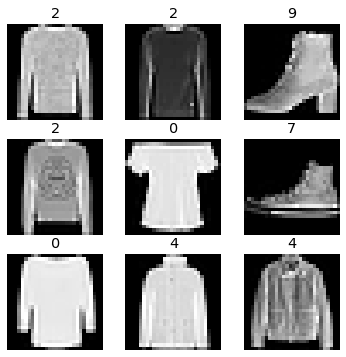

In [ ]:
random_sample = np.random.choice(np.arange(len(data)), 9)
gen.visualize_subplot(
    data[random_sample].reshape(-1, 28, 28),
    target[random_sample],  (3, 3), (6, 6)
)

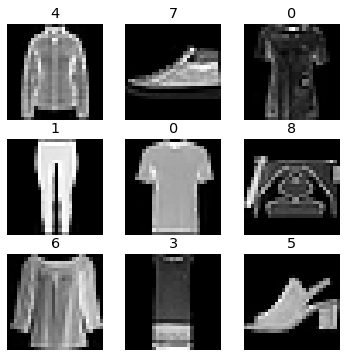

In [ ]:
random_sample = np.random.choice(np.arange(len(data)), 9)
gen.visualize_subplot(
    data[random_sample].reshape(-1, 28, 28),
    target[random_sample],  (3, 3), (6, 6)
)

In [ ]:
target_classes = ["T-Shirt/Top", "Trouser", "Pullover", "Dress", 
                  "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [ ]:
target_distribution = pd.Series(target).value_counts().sort_index()
target_distribution.index = target_classes

In [ ]:
target_distribution

T-Shirt/Top    7000
Trouser        7000
Pullover       7000
Dress          7000
Coat           7000
Sandal         7000
Shirt          7000
Sneaker        7000
Bag            7000
Ankle Boot     7000
dtype: int64

# **Trabajo asíncrono**

### **Train Set, Validation Set, Test Set**
- Partición de datasets:
    - Train Data:
        - Train Set
        - Validation Set
    - Test Data:
        - Test Set
        
Divición nuestro dataset a partir de sus índices.

In [ ]:
rnd_data = np.random.choice(np.arange(len(data)), 10000)
full_data = data.copy()
full_target = target.copy()
data = data[rnd_data]
target = target[rnd_data]

### **1. Partición del dataset que garatiza que se mantienen las proporciones de cada clase por cada partición, usando StratifiedShufflesplit**<a name="id1"></a>

Con el mismo conjunto de imágenes, o con el de mnist de dígitos, hacer una partición del dataset que garatice que se mantienen las proporciones de cada clase por cada partición. Para esto, usarán [`StratifiedShufflesplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection). 

In [ ]:
sss_full_train_test = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)

In [ ]:
for full_train_index, test_index in sss_full_train_test.split(data, target):
    pass

In [ ]:
full_train_index

array([7166, 9556,   88, ..., 3225, 7171, 7243])

In [ ]:
test_index

array([9060, 3071, 9183, ..., 7747, 6135, 3805])

In [ ]:
full_train_set, test_set = ((data[full_train_index], target[full_train_index]), 
                            (data[test_index], target[test_index]))

In [ ]:
sss_train_val = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=5678)

In [ ]:
for train_index, val_index in sss_train_val.split(full_train_set[0], full_train_set[1]):
    pass

In [ ]:
train_set, val_set = ((full_train_set[0][train_index], full_train_set[1][train_index]), 
                      (full_train_set[0][val_index], full_train_set[1][val_index]))

In [ ]:
X_train, y_train = train_set[0], train_set[1]
X_val, y_val = val_set[0], val_set[1]
X_test, y_test = test_set[0], test_set[1]

In [ ]:
X_train.shape, y_train.shape

((6400, 784), (6400,))

In [ ]:
X_val.shape, y_val.shape

((1600, 784), (1600,))

In [ ]:
X_test.shape, y_test.shape

((2000, 784), (2000,))

- Generemos una muestra de imágenes por cada set generado.

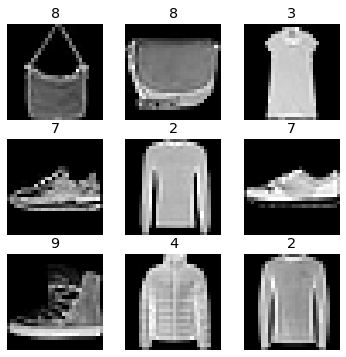

In [ ]:
random_sample = np.random.choice(np.arange(len(X_train)), 9)
gen.visualize_subplot(
    X_train[random_sample].reshape(-1, 28, 28),
    y_train[random_sample],  (3, 3), (6, 6)
)

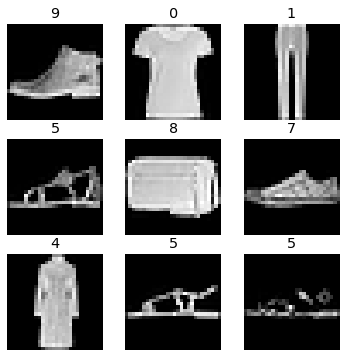

In [ ]:
random_sample = np.random.choice(np.arange(len(X_val)), 9)
gen.visualize_subplot(
    X_val[random_sample].reshape(-1, 28, 28),
    y_val[random_sample],  (3, 3), (6, 6)
)

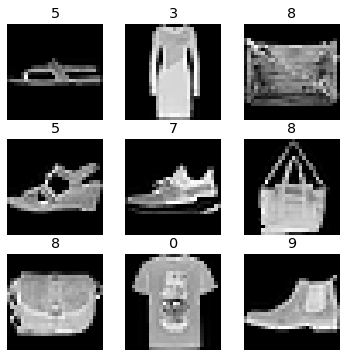

In [ ]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 28, 28),
    y_test[random_sample],  (3, 3), (6, 6)
)

## **Modelamiento**<a name="id6"></a>
- A la hora de modelar los datos, buscamos un algoritmo que generalice la forma como los datos se comportan y con base en ello, pueda generar predicciones.

### **K-Nearest-Neighbors**
- Es un algoritmo de modelado no lineal basado en vecindades o *neighborhoods*. Se trata de *K-Nearest Neighbors*.


In [ ]:
KNeighborsClassifier?

- En este caso, se utiliza el valor de vecinos por defecto, que es el `k=5`

In [ ]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [ ]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

## **Predicción**<a name="id7"></a>
- En esta etapa nos concentramos en hacer nuestras predicciones y validarlas con el ojo.

In [ ]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
y_pred = knn_clf.predict(X_test[random_sample])

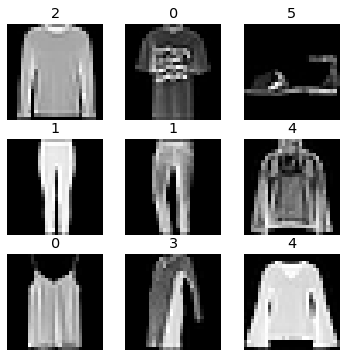

In [ ]:
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 28, 28),
    y_pred, (3, 3), (6, 6)
)

In [ ]:
y_pred = knn_clf.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
pd.DataFrame(conf_matrix)

,0,1,2,3,4,5,6,7,8,9
0,177,0,7,2,1,0,14,0,1,0
1,4,193,1,6,1,0,0,0,0,0
2,1,0,153,3,28,0,17,0,0,0
3,10,1,2,167,11,0,6,0,0,0
4,3,0,36,8,141,0,10,0,0,0
5,0,0,0,0,0,154,4,21,0,14
6,40,0,30,5,21,0,99,0,2,0
7,0,0,0,0,0,0,0,185,0,10
8,1,0,5,0,3,1,10,1,187,0
9,0,0,0,0,0,3,1,9,0,190


- En esta matriz de confusión podemos ver claramente que las diagonales sobresalen, es decir, hubo un gran número de predicciones correctas.

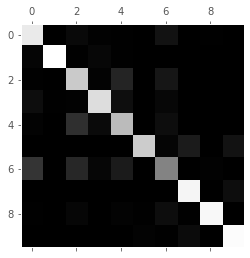

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.grid(0)
plt.show()

In [ ]:
np.trace(conf_matrix)

1646

In [ ]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

- Aquí vemos que, aunque nuestro algoritmo clasificó correctamente alrededor del 80% de nuestro dataset, siempre las clasificaciones erróneas fueron bastantes.

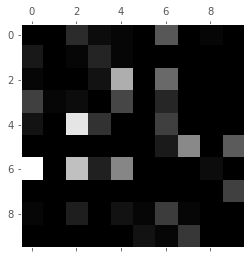

In [ ]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.grid(0)
plt.show()

### **2. Gráfica de variación del rendimiento sobre entrenamiento y validación a medida que aumenta el valor de k.**<a name="id2"></a>

Luego, construir una gráfica que muestre cómo varía el rendimiento sobre entrenamiento y validación a medida que aumenta el valor de k. A partir de esta gráfica, mostrar el rendimiento sobre el test set con el valor de k seleccionado.

In [ ]:
accuracy_score(y_test, y_pred)

0.823

In [ ]:
precision_score(y_test, y_pred, average="weighted")

0.8282522302124184

In [ ]:
recall_score(y_test, y_pred, average="weighted")

0.823

In [ ]:
f1_score(y_test, y_pred, average="weighted")

0.822723143548495

##### **Rendimiento sobre entrenamiento y validación a medida que aumenta el valor de k.** 

In [ ]:
acc_scores = {}
for k in tqdm(range(1, 18, 2)):
    knn_clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_val)
    acc_scores[k] = accuracy_score(y_val, y_pred)
    print(f"------Number of Neighbors: {k}--------")
    print(f"Accuracy Score: {acc_scores[k]}")


------Number of Neighbors: 1--------
Accuracy Score: 0.81
------Number of Neighbors: 3--------
Accuracy Score: 0.811875
------Number of Neighbors: 5--------
Accuracy Score: 0.823125
------Number of Neighbors: 7--------
Accuracy Score: 0.8175
------Number of Neighbors: 9--------
Accuracy Score: 0.811875
------Number of Neighbors: 11--------
Accuracy Score: 0.813125
------Number of Neighbors: 13--------
Accuracy Score: 0.81375
------Number of Neighbors: 15--------
Accuracy Score: 0.811875
------Number of Neighbors: 17--------
Accuracy Score: 0.814375



In [ ]:
total_data = {
    "neighbors": list(range(1, 18, 2)),
    "acc_scores": list(acc_scores.values()),
}

total_df = pd.DataFrame(total_data)

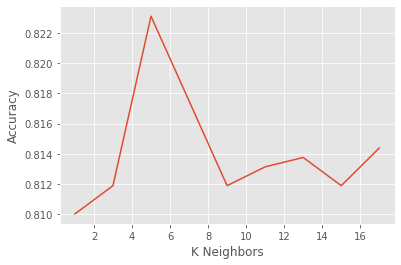

In [ ]:
plt.plot(total_df["neighbors"], total_df["acc_scores"])
plt.xlabel("K Neighbors")
plt.ylabel("Accuracy")
plt.show()

#### **Rendimiento sobre el test set con el valor de k seleccionado  (k=5)**
Dado que el pico en la gráfica de Accuracy vs k, dió como el mayor (y mejor) resultado k=5 con accuracy 0.823125. Tomamos dicho parámetro para evaluar el rendimiento del algoritmo sobre los datos del test set

In [ ]:
knn_best = KNeighborsClassifier(n_neighbors= 5, n_jobs=-1)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
y_pred_best = knn_best.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_best)

0.823

In [ ]:
precision_score(y_test, y_pred_best, average="weighted")

0.8282522302124184

In [ ]:
recall_score(y_test, y_pred_best, average="weighted")

0.823

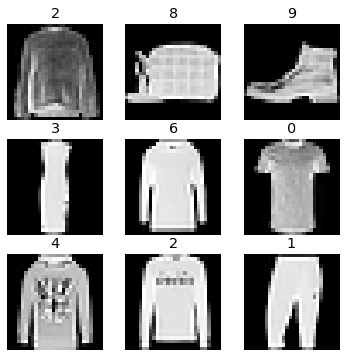

In [ ]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
y_pred = knn_best.predict(X_test[random_sample])
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 28, 28),
    y_pred, (3, 3), (6, 6)
)

### **3. Mejores valores de los hiperparámetros usando GridSearch**<a name="id3"></a>

A continuación, utilizar [`GridSearch`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para determinar los mejores valores de los hiperparámetros. Para eso, averiguar sobre los siguientes hiperparámetros:
    - `n_neighbors`
    - `weights`
    - `algorithm`

#### **Parámetro n_neighbors hasta 5**

In [ ]:
grid_params1 = dict(n_neighbors=list(range(5)), weights=['uniform', 'distance'], algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'], metric=['minkowski'])

In [ ]:
gs1 = GridSearchCV(knn_clf, grid_params1, verbose=1, n_jobs= -1, cv=3, scoring = 'accuracy')
gs1_results = gs1.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 12.1min finished


In [ ]:
gs1_results.best_params_

{'algorithm': 'auto',
 'metric': 'minkowski',
 'n_neighbors': 4,
 'weights': 'distance'}

In [ ]:
gs1_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
gs1_results.best_score_

0.8196872226843083

#### **Parámetro n_neighbors hasta 10**

In [ ]:
grid_params = dict(n_neighbors=list(range(10)), weights=['uniform', 'distance'], algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'], metric=['minkowski'])
gs = GridSearchCV(knn_clf, grid_params, verbose=1, n_jobs= -1, cv=3, scoring = 'accuracy')
gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 26.9min finished


In [ ]:
gs_results.best_params_

{'algorithm': 'auto',
 'metric': 'minkowski',
 'n_neighbors': 4,
 'weights': 'distance'}

In [ ]:
gs_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
gs_results.best_score_

0.8196872226843083

### **4. Imágenes del conjunto test con la clase estimada por el mejor clasificador obtenido en el punto anterior**<a name="id4"></a>

Por último, mostrar algunas imágenes del conjunto test con la clase estimada por el mejor clasificador obtenido en el punto anterior y mostrarlos en una cuadrícula.

In [ ]:
knn_best_estim = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
knn_best_estim.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
y_pred_best_estim = knn_best_estim.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_best_estim)

0.84

In [ ]:
precision_score(y_test, y_pred_best_estim, average="weighted")

0.8437990337579322

In [ ]:
recall_score(y_test, y_pred_best_estim, average="weighted")

0.84

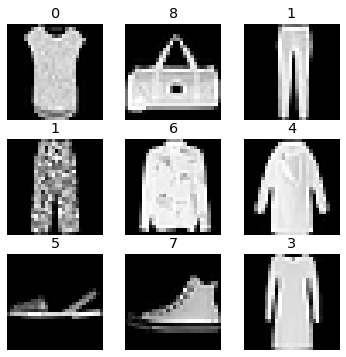

In [ ]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
y_pred = knn_best.predict(X_test[random_sample])
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 28, 28),
    y_pred, (3, 3), (6, 6)
)